<a href="https://colab.research.google.com/github/lubaochuan/ml_python/blob/main/ISLP_chapter2_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# ISLP Chapter 2 – Guided Lab: Statistical Learning (Hands-on)

This lab builds intuition for the fundamental ideas in Chapter 2:
- prediction vs inference
- supervised vs unsupervised learning
- parametric vs non-parametric models
- training vs test error
- overfitting and the bias–variance tradeoff
- irreducible error (noise floor)

You will run short experiments and answer reflection questions as you go.


## Step 0: Setup

In [2]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

np.random.seed(0)



## Step 1: Prediction vs Inference (Quick demo)

We create a dataset where we know the true relationship.

- **Inference:** Which input matters and how?
- **Prediction:** How well can we predict new outputs?


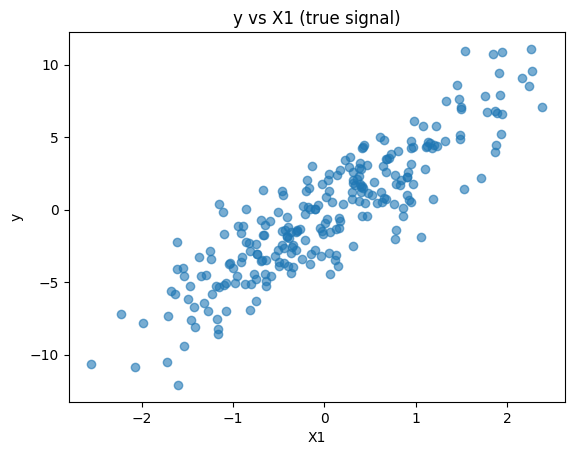

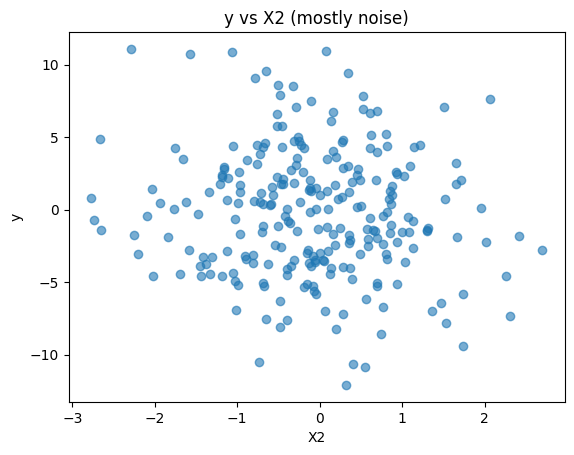

In [3]:

n = 250
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)

# True relationship: y depends on X1, not X2
y = 4*X1 + np.random.normal(0, 2, n)

X = np.column_stack([X1, X2])

plt.scatter(X1, y, alpha=0.6)
plt.xlabel("X1")
plt.ylabel("y")
plt.title("y vs X1 (true signal)")
plt.show()

plt.scatter(X2, y, alpha=0.6)
plt.xlabel("X2")
plt.ylabel("y")
plt.title("y vs X2 (mostly noise)")
plt.show()



### Reflection
1. Which variable looks related to y?
2. Which plot looks like mostly noise?


## Step 2: Train/Test Split (Generalization)

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

yhat_train = lr.predict(X_train)
yhat_test = lr.predict(X_test)

print("Linear Regression")
print("  Train MSE:", round(mean_squared_error(y_train, yhat_train), 3))
print("  Test  MSE:", round(mean_squared_error(y_test, yhat_test), 3))
print("  Test  R2 :", round(r2_score(y_test, yhat_test), 3))
print("  Coefs   :", lr.coef_, "Intercept:", round(lr.intercept_, 3))


Linear Regression
  Train MSE: 3.99
  Test  MSE: 4.288
  Test  R2 : 0.77
  Coefs   : [3.89424446 0.11155242] Intercept: -0.321



### Discussion prompts
- Why is test error usually higher than training error?
- Which coefficient should be near 4? Which should be near 0?


## Step 3: Parametric vs Non-Parametric (Linear Regression vs k-NN)


We create a nonlinear dataset. Linear regression is parametric (straight line), while k-NN is non-parametric (local averaging).


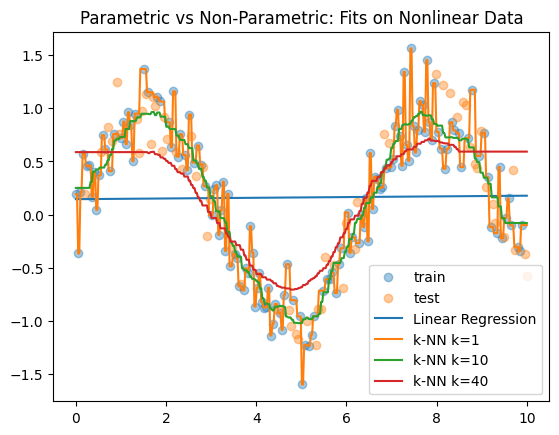

        LinReg  Train MSE=0.465  Test MSE=0.538
       kNN k=1  Train MSE=0.000  Test MSE=0.114
      kNN k=10  Train MSE=0.054  Test MSE=0.059
      kNN k=40  Train MSE=0.139  Test MSE=0.177


In [5]:

X = np.linspace(0, 10, 200).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.25, size=len(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

lr = LinearRegression().fit(X_train, y_train)
knn1 = KNeighborsRegressor(n_neighbors=1).fit(X_train, y_train)
knn10 = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)
knn40 = KNeighborsRegressor(n_neighbors=40).fit(X_train, y_train)

xx = np.linspace(0, 10, 400).reshape(-1, 1)
plt.scatter(X_train, y_train, alpha=0.4, label="train")
plt.scatter(X_test, y_test, alpha=0.4, label="test")
plt.plot(xx, lr.predict(xx), label="Linear Regression")
plt.plot(xx, knn1.predict(xx), label="k-NN k=1")
plt.plot(xx, knn10.predict(xx), label="k-NN k=10")
plt.plot(xx, knn40.predict(xx), label="k-NN k=40")
plt.legend()
plt.title("Parametric vs Non-Parametric: Fits on Nonlinear Data")
plt.show()

def report(name, model):
    tr = mean_squared_error(y_train, model.predict(X_train))
    te = mean_squared_error(y_test, model.predict(X_test))
    print(f"{name:>14}  Train MSE={tr:.3f}  Test MSE={te:.3f}")

report("LinReg", lr)
report("kNN k=1", knn1)
report("kNN k=10", knn10)
report("kNN k=40", knn40)



### Reflection
1. Which model looks like it is overfitting?
2. Which model looks like it is underfitting?
3. Which k seems to generalize best here?


## Step 4: Bias–Variance Tradeoff (Systematic experiment)

We vary k and plot training vs test MSE.

In [ ]:

ks = list(range(1, 61, 2))
train_mse = []
test_mse = []

for k in ks:
    m = KNeighborsRegressor(n_neighbors=k).fit(X_train, y_train)
    train_mse.append(mean_squared_error(y_train, m.predict(X_train)))
    test_mse.append(mean_squared_error(y_test, m.predict(X_test)))

plt.plot(ks, train_mse, label="Train MSE")
plt.plot(ks, test_mse, label="Test MSE")
plt.xlabel("k (neighbors)")
plt.ylabel("MSE")
plt.title("Bias–Variance Tradeoff via k in k-NN")
plt.legend()
plt.show()

best_k = ks[int(np.argmin(test_mse))]
print("Best k (lowest test MSE):", best_k)



### Discussion prompts
- Why does training error increase as k increases?
- Why does test error usually have a “sweet spot”?


## Step 5: Unsupervised Learning (Clustering demo)

No labels y: we cluster points into groups using k-means.

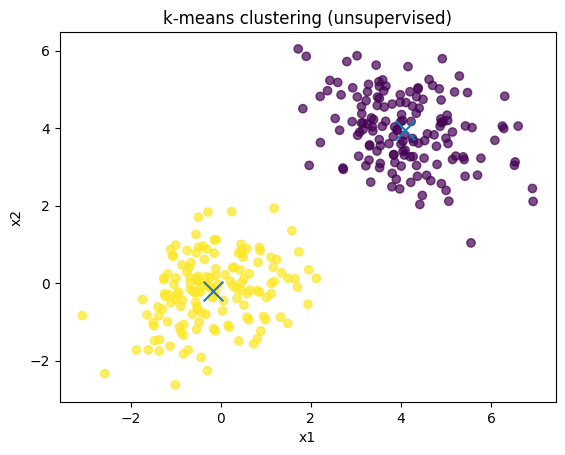

In [6]:

A = np.random.multivariate_normal([0,0], [[1,0.2],[0.2,1]], 150)
B = np.random.multivariate_normal([4,4], [[1,-0.3],[-0.3,1]], 150)
X_u = np.vstack([A, B])

kmeans = KMeans(n_clusters=2, n_init=10, random_state=0).fit(X_u)
labels = kmeans.labels_

plt.scatter(X_u[:,0], X_u[:,1], c=labels, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], marker="x", s=200)
plt.title("k-means clustering (unsupervised)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()



### Reflection
1. How is clustering different from supervised learning?
2. What does “k” mean in k-means?


## Step 6: Irreducible Error (Noise floor)

We simulate the same pattern with low vs high noise and compare test error.

In [7]:

def simulate(noise_sigma):
    X = np.linspace(0, 10, 200).reshape(-1, 1)
    y = np.sin(X).ravel() + np.random.normal(0, noise_sigma, size=len(X))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    m = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)
    return mean_squared_error(y_test, m.predict(X_test))

low = simulate(0.1)
high = simulate(0.8)
print("Test MSE with low noise :", round(low, 3))
print("Test MSE with high noise:", round(high, 3))


Test MSE with low noise : 0.013
Test MSE with high noise: 0.69


### Discussion
Why can’t we drive the error to zero when noise is high?


# Review Questions (for discussion)

1. In plain language, what does the equation y = f(X) + ε mean?
2. What’s the difference between prediction and inference?
3. What’s the difference between supervised and unsupervised learning?
4. In the k-NN experiment, what happens when k is very small? very large?
5. Why do we use a train/test split?
6. What is overfitting, and how did you observe it?
7. What is the bias–variance tradeoff?
8. What does “irreducible error” mean?



<details>

<summary>Answer Key</summary>

1. y is generated by some unknown pattern f(X) plus random noise ε.
2. Prediction focuses on accuracy on new data; inference focuses on understanding relationships.
3. Supervised learning has labels (y); unsupervised learning has no labels and finds structure.
4. Small k: very flexible, low bias/high variance, can overfit. Large k: smoother, higher bias/lower variance, can underfit.
5. To estimate generalization performance on unseen data.
6. Overfitting is fitting noise; k=1 often had very low train error but worse test error.
7. As flexibility increases, bias decreases but variance increases; best test error is a balance.
8. Error that remains even with the best possible model because of randomness/noise.
</details>